## TCEQ Data Processing
The purpose of this notebook is to aggragate all of the TCEQ data that I have downloaded off of the TCEQ website and save in a csv. The file formats are different during different periods thus various data processing steps are necessary for each time period. 

Jan and Feb data can be gathered from the two excel files included in the 'tceq_folder'
March and April data is available in raw data files identified below. 

One excel file includes all of Jan and the second half of Feb and the other excel file includes the first half of Feb.

<b>TODO:</b> <br/>
1. Load data from October and November.
1. Develope code to handle downloads from the TCEQ website and files that I have scraped off of the TCEQ website. 
2. Make uniform graphs to compair sites. 
3. Plot data on a map.

In [1]:
import pandas as pd # python library taking the place of the spreadsheet part of excel
import matplotlib.pyplot as plt # python library for the graphing part of excel
import sys, os

In [15]:
tceq_folder = 'C:/Users/duvallwh/Documents/_WeatherProjects/CPS/CPS - Sensor Evaluation/TCEQ'
file_list = os.listdir(tceq_folder)
file_path = [os.path.join(tceq_folder, x) for x in file_list]
excel_files = [x for x in file_path if 'xlsx' in x]

In [16]:
# process the excel file with Jan and Feb data
ef = pd.ExcelFile(excel_files[1])
jan = ef.parse('jan', skiprows=1)
feb = ef.parse('feb', skiprows=1)
dat_1 = pd.concat([jan, feb])
dat_1.rename(columns={'parm':'datetime'}, inplace=True)
dat_1['datetime'] = pd.to_datetime(dat_1['datetime'], format="%Y-%m-%d %H:%M:%S", errors='coerce')
dat_1.dropna(subset=['datetime'], inplace=True)
dat_1.drop(['NOx', 'wd', 'ws'], inplace=True, axis=1)

In [17]:
# process the second excel file with the begining of Feb
parm_list = ['NO', 'NO2', 'PM25', 'Temp', 'RH']
ef = pd.ExcelFile(excel_files[0])
full_dat = ef.parse('Ozone', skiprows=4)[['Date', 'TCEQ']]
full_dat.rename(columns={'TCEQ':'Ozone'}, inplace=True)
for x in parm_list:
    dat = ef.parse(x, skiprows=4)[['Date', 'TCEQ']]
    dat.rename(columns={'TCEQ':x}, inplace=True)
    full_dat = full_dat.merge(dat, on='Date')  
# make both columns uniform
dat_1.rename(columns={'datetime':'Date', 'rh':'RH', 'temp':'Temp',
                     'PM2.5':'PM25', 'ozone':'Ozone'}, inplace=True)
dat = pd.concat([dat_1, full_dat])
old_dat = dat[dat['Date'].duplicated() == False]

In [18]:
del(dat)

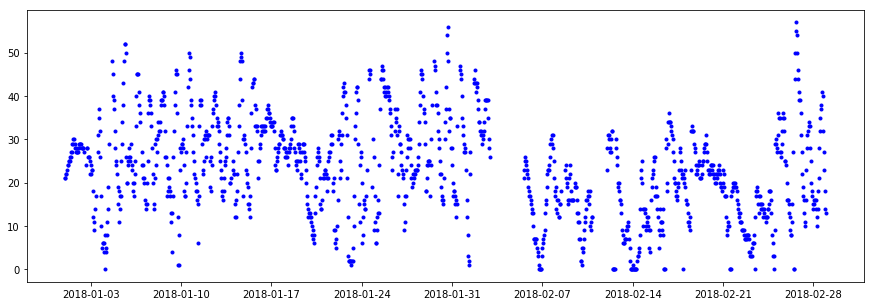

In [21]:
plt.figure(figsize=(15, 5))
plt.plot(old_dat['Date'].values, old_dat['Ozone'], 'b.')
plt.show()

In [47]:
old_dat.head()

,Date,NO,NO2,Ozone,PM25,RH,Temp
1,2018-01-01 00:00:00,-0.4,1.4,21.0,4.0,75.2,30.4
2,2018-01-01 01:00:00,-0.2,1.2,21.0,3.5,76.4,30.2
3,2018-01-01 02:00:00,0.3,1.2,22.0,5.3,73.1,29.9
4,2018-01-01 03:00:00,-0.5,1.2,22.0,5.4,70.0,29.4
5,2018-01-01 04:00:00,0.1,1.4,23.0,4.2,64.3,28.9


In [30]:
folder_path = 'C:/Users/duvallwh/Documents/_WeatherProjects/CPS/CPS - Sensor Evaluation/TCEQ'
long_files = ['tceq_3.csv', 'tceq_rest_of_3.csv', 'tceq_4.csv', 'tceq_oct.csv', 
              'tceq_nov.csv']
long_files_path = [os.path.join(folder_path, x) for x in long_files]

def load_tceq_long(file_path):
    """Read TCEQ files that have been scraped from the website."""
    dat = pd.read_csv(file_path,
                      dtype={'hour':'object'})
    dat['value'] = pd.to_numeric(dat['value'], errors='cource')
    dat['datetime'] = dat['date'] + " " + dat['hour']  + ":00"
    dat['Date'] = pd.to_datetime(arg=dat.pop('datetime'), format='%Y-%m-%d %H:%M')
    return dat
    


In [33]:
new_dat = pd.DataFrame()

for file in long_files_path:
    dat = load_tceq_long(file)
    new_dat = pd.concat([new_dat, dat])
    

In [35]:
CAMS59 = new_dat[new_dat["site"] == 59]
CAMS5004 = new_dat[new_dat["site"] == 5004]
# new_dat.drop([], inplace=True, axis=1)

In [41]:
parameter_dict = {42601:"NO", 
                  42602:"NO2", 
                  44201:"Ozone",
                  62101:"Temp",
                  62201:"RH",
                  88502:"PM25"}

In [42]:
cams59 = CAMS59.pivot(index='Date', columns='parameter', values='value')
cams5004 = CAMS5004.pivot(index='Date', columns='parameter', values='value')

In [43]:
cams5004.rename(columns=parameter_dict, inplace=True)
cams59.rename(columns=parameter_dict, inplace=True)

In [45]:
cams5004.columns

Index([61103, 61104, 'Temp', 'RH'], dtype='object', name='parameter')

In [46]:
c = list(cams5004.columns)
c.remove('RH')
cams5004.drop(c, inplace=True, axis=1)

In [47]:
# cams59.drop([11100, 61103, 61104], inplace=True, axis=1)
cams59['Date'] = cams59.index
cams5004['Date'] = cams5004.index

In [48]:
new = cams59.merge(cams5004, on=['Date'])

In [50]:
new.columns

Index(['NO', 'NO2', 42603, 'Ozone', 'Temp', 'PM25', 'Date', 'RH'], dtype='object', name='parameter')

In [49]:
new.drop([11100, 61103, 61104], inplace=True, axis=1)

In [51]:
dat = pd.concat([old_dat, new])

In [52]:
dat.to_csv('C:/users/duvallwh/desktop/tceq.csv', index_label=False)